In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import urllib.request

plt.rcParams['figure.figsize'] = [10, 6]


def download_supernova_json(supernova_name):
    # Define a dictionary mapping supernova years to their respective repositories
    year_to_repo = {
        "pre-1990": "sne-pre-1990",
        "1990-1999": "sne-1990-1999",
        "2000-2004": "sne-2000-2004",
        "2005-2009": "sne-2005-2009",
        "2010-2014": "sne-2010-2014",
        "2015-2019": "sne-2015-2019",
        "2020-2024": "sne-2020-2024"
    }

    # Extract the year from the supernova name
    year = int(supernova_name[2:6])

    # Find the corresponding repository based on the year
    found_repo = None
    if year < 1990:
        found_repo = year_to_repo["pre-1990"]
    else:
        for year_range, repo in year_to_repo.items():
            if year_range.startswith("pre"):
                continue
            else:
                start_year, end_year = map(int, year_range.split('-'))
                if start_year <= year <= end_year:
                    found_repo = repo
                    break
    
    if found_repo is None:
        print("Error: Year not found.")
        return

    # Construct the URL based on the supernova name and repository
    url = f"https://raw.githubusercontent.com/astrocatalogs/{found_repo}/main/{supernova_name}.json"
    
    print("Attempting to fetch from \n ", url)
    
    # Define the filename to save the JSON file
    filename = f"{supernova_name}.json"

    # Check if the file already exists
    if not os.path.exists(filename):
        # Download the file
        urllib.request.urlretrieve(url, filename)
        print(f"File downloaded successfully: {filename}")
    else:
        print("File already exists.")

# Example usage


In [2]:
SN = 'SN2011fe'

download_supernova_json(SN)

Attempting to fetch from 
  https://raw.githubusercontent.com/astrocatalogs/sne-2010-2014/main/SN2011fe.json
File already exists.


In [3]:

#JSON file acquired from https://github.com/astrocatalogs/supernovae

# Read JSON file

with open(SN+'.json', 'r') as file:
    data = json.load(file)

    
sn = data[SN]

sn.keys()

dict_keys(['schema', 'name', 'sources', 'alias', 'claimedtype', 'comovingdist', 'dec', 'discoverdate', 'discoverer', 'ebv', 'host', 'hostdec', 'hostoffsetang', 'hostoffsetdist', 'hostra', 'hostvelocity', 'lumdist', 'maxabsmag', 'maxappmag', 'maxband', 'maxdate', 'maxvisualabsmag', 'maxvisualappmag', 'maxvisualband', 'maxvisualdate', 'ra', 'redshift', 'velocity', 'photometry', 'spectra'])

In [4]:
#use this link to find out what the keys mean and understand the structure
sn['schema']

'https://github.com/astrocatalogs/supernovae/blob/d3ef5fc/SCHEMA.md'

In [5]:
sn['dec']

[{'value': '+54:16:25.22', 'u_value': 'degrees', 'source': '24,43'},
 {'value': '+54:16:25.32', 'u_value': 'degrees', 'source': '13'},
 {'value': '+54:16:25.4', 'u_value': 'degrees', 'source': '45'},
 {'value': '+54:16:25.3', 'u_value': 'degrees', 'source': '32,37'}]

In [6]:
sn['sources']

[{'name': '2020MNRAS.492.4325S',
  'bibcode': '2020MNRAS.492.4325S',
  'reference': 'Stahl et al. (2020)',
  'alias': '1'},
 {'name': '2019MNRAS.490.3882S',
  'bibcode': '2019MNRAS.490.3882S',
  'reference': 'Stahl et al. (2019)',
  'alias': '2'},
 {'name': '2017MNRAS.466.3442J',
  'bibcode': '2017MNRAS.466.3442J',
  'reference': 'Johansson et al. (2017)',
  'alias': '3'},
 {'name': '2017MNRAS.472.3437G',
  'bibcode': '2017MNRAS.472.3437G',
  'reference': 'Graham et al. (2017)',
  'alias': '4'},
 {'name': '2017arXiv170302402W',
  'bibcode': '2017arXiv170302402W',
  'reference': 'Weyant et al. (2017)',
  'alias': '5'},
 {'name': '2016A&A...594A..13P',
  'bibcode': '2016A&A...594A..13P',
  'reference': 'Planck Collaboration et al. (2016)',
  'alias': '6'},
 {'name': '2016PASP..128...961',
  'bibcode': '2016PASP..128...961',
  'alias': '7'},
 {'name': '2015ApJS..220....9F',
  'bibcode': '2015ApJS..220....9F',
  'reference': 'Friedman et al. (2015)',
  'alias': '8'},
 {'name': '2015MNRAS.4

In [7]:

photometry = sn['photometry']

photometry[0]

{'time': '54975.239',
 'band': 'g',
 'countrate': '3.3',
 'e_countrate': '28.7',
 'e_upper_magnitude': '0.1975',
 'instrument': 'PTF48',
 'magnitude': '21.61',
 'u_countrate': 's^-1',
 'u_time': 'MJD',
 'upperlimit': True,
 'upperlimitsigma': '5.0',
 'zeropoint': '27.',
 'source': '9'}

In [30]:
# we need to format the JSON data in two different ways: plotting requires us to separate by band so we can loop 
# over and color code, etc. SALT fitting requires the photometry to be in time order with a band, magnitude, magnitude error, etc.
# the SALT is in the master_* arrays, the plotting arrays are in the dictionary photometry_by_band


photometry_by_band = {}

master_band = []
master_time = []
master_mag = []
master_emag = []
master_magsys = []
master_zp = []

# Define a dictionary to map band names to their corresponding keys. the keys are the registered bandpasses used 
# for the SALT fit
band_map = {
    'U': 'standard::u',
    'B': 'standard::b',
    'V': 'standard::v',
    'R': 'standard::r',
    'I': 'standard::i'
}

for entry in photometry:
    if all(key in entry for key in ['time', 'band', 'magnitude', 'e_magnitude']):
        if entry['band'] in band_map:  # Check if the band is one of 'U', 'B', 'V', 'R', or 'I'
            try:
                band = band_map[entry['band']]
                magnitude = entry['magnitude']

                master_time.append(float(entry['time']))
                master_band.append(band)
                master_mag.append(float(entry['magnitude']))
                master_emag.append(float(entry['e_magnitude']))
                master_magsys.append('vega')  # CHECK IF THIS IS LISTED, SOME DO
                master_zp.append(25.)  # CHECK IF THIS IS LISTED, SOME DO
                
                if band not in photometry_by_band:
                    photometry_by_band[band] = {'times': [], 'magnitudes': [], 'bands': [], 'e_magnitudes': []}
                
                photometry_by_band[band]['times'].append(float(entry['time']))
                photometry_by_band[band]['magnitudes'].append(float(entry['magnitude']))
                photometry_by_band[band]['bands'].append(band)
                photometry_by_band[band]['e_magnitudes'].append(float(entry['e_magnitude']))
                
            except Exception as e:
                print("Skipping:", e)
        else:
            print("Skipping: Invalid band:", entry['band'])

Skipping: Invalid band: g'
Skipping: Invalid band: g'
Skipping: Invalid band: g'
Skipping: Invalid band: g'
Skipping: Invalid band: UVW1
Skipping: Invalid band: UVW1
Skipping: Invalid band: g'
Skipping: Invalid band: g
Skipping: Invalid band: r
Skipping: Invalid band: g'
Skipping: Invalid band: g'
Skipping: Invalid band: g'
Skipping: Invalid band: g'
Skipping: Invalid band: g'
Skipping: Invalid band: Rc
Skipping: Invalid band: UVW1
Skipping: Invalid band: UVW2
Skipping: Invalid band: UVM2
Skipping: Invalid band: UVW1
Skipping: Invalid band: UVW2
Skipping: Invalid band: UVM2
Skipping: Invalid band: UVW1
Skipping: Invalid band: UVW2
Skipping: Invalid band: UVM2
Skipping: Invalid band: UVW1
Skipping: Invalid band: UVW2
Skipping: Invalid band: UVM2
Skipping: Invalid band: UVW1
Skipping: Invalid band: UVW2
Skipping: Invalid band: UVM2
Skipping: Invalid band: g
Skipping: Invalid band: g
Skipping: Invalid band: g
Skipping: Invalid band: r
Skipping: Invalid band: g
Skipping: Invalid band: g
Sk

Skipping: Invalid band: Rc
Skipping: Invalid band: Ic
Skipping: Invalid band: Rc
Skipping: Invalid band: Ic
Skipping: Invalid band: Rc
Skipping: Invalid band: Ic
Skipping: Invalid band: Rc
Skipping: Invalid band: Ic
Skipping: Invalid band: Rc
Skipping: Invalid band: Ic
Skipping: Invalid band: Rc
Skipping: Invalid band: Ic
Skipping: Invalid band: Rc
Skipping: Invalid band: Ic
Skipping: Invalid band: Rc
Skipping: Invalid band: Ic
Skipping: Invalid band: Rc
Skipping: Invalid band: Ic
Skipping: Invalid band: Rc
Skipping: Invalid band: Ic
Skipping: Invalid band: Rc
Skipping: Invalid band: Ic
Skipping: Invalid band: Rc
Skipping: Invalid band: Ic
Skipping: Invalid band: Rc
Skipping: Invalid band: Ic
Skipping: Invalid band: Rc
Skipping: Invalid band: Ic
Skipping: Invalid band: Rc
Skipping: Invalid band: I1
Skipping: Invalid band: I2
Skipping: Invalid band: Ic
Skipping: Invalid band: Rc
Skipping: Invalid band: Ic
Skipping: Invalid band: Rc
Skipping: Invalid band: Ic
Skipping: Invalid band: Rc
S

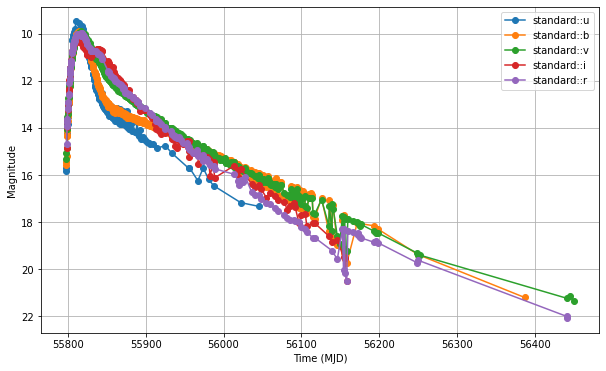

In [31]:
# Plot photometry for each band and telescope
for band, data in photometry_by_band.items():
    plt.plot(data['times'], data['magnitudes'], marker='o', linestyle='-', label=f'{band}')
    plt.xlabel('Time (MJD)')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.grid(True)
plt.gca().invert_yaxis()  # Invert y-axis since brighter means lower magnitude
#plt.xlim(55750,56500)
plt.show()

In [32]:
spectra = sn['spectra']
#spectra

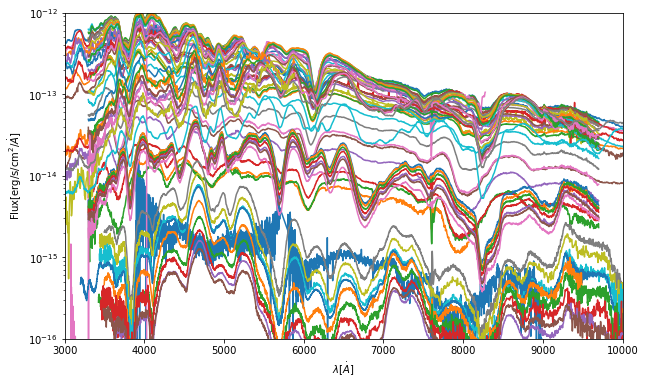

In [33]:
spectra_by_time = {}
for spectrum in spectra:
    if (spectrum['u_fluxes'] == 'erg/s/cm^2/Angstrom'):
        try:
            time = spectrum['time']
            wavelengths = [float(entry[0]) for entry in spectrum['data']]
            flux = [float(entry[1]) for entry in spectrum['data']]
    #        magnitude = entry['magnitude']
    #        if band not in photometry_by_band:
    #            photometry_by_band[band] = {'times': [], 'magnitudes': []}
    #        photometry_by_band[band]['times'].append(float(entry['time']))
    #        photometry_by_band[band]['magnitudes'].append(float(entry['magnitude']))
    
            plt.plot(wavelengths,flux)
            plt.yscale('log')
            plt.xlim(3000,10000)
            plt.ylim(1e-16,1e-12)
            plt.xlabel('$\lambda[\dot{A}]$')
            plt.ylabel('Flux[erg/s/cm$^2/\dot{A}$]')
    #
        except:
            print("skipping")
            
        


In [38]:

import sncosmo
from astropy.table import Table


def mag_to_flux(magnitudes, magnitude_errors, zero_point=25.):
    
    magnitudes = np.array(magnitudes)
    magnitude_errors = np.array(magnitude_errors)

    # Convert magnitudes to fluxes
    fluxes = 10 ** (-0.4 * (magnitudes - zero_point))
    
    # Calculate flux errors
    flux_errors = 0.4 * np.log(10) * fluxes * magnitude_errors
    
    return fluxes, flux_errors

zero_point=25.

master_flux, master_eflux = mag_to_flux(master_mag, master_emag, zero_point)


# Define your data
photometric_data = {
    'band': master_band,       # Example bands
    'time': master_time,       # Example times
    'flux': master_flux,         # Example magnitudes
    'flux_error': master_eflux,      # Example magnitude errors
    'zp': master_zp,
    'zpsys': master_magsys      
}

# Create a data table
data_table = Table(photometric_data)

# Define the SALT2 model
model = sncosmo.Model(source='salt2')


# Fit the model to the data
result, fitted_model = sncosmo.fit_lc(data_table, model,
    ['z', 't0', 'x0', 'x1', 'c'],  # parameters of model to vary
    bounds={'z':(0.0, 0.1)})  # bounds on parameters (if any)

# Print fit parameters
print(result)

# Plot the fit


/Users/pmacias/opt/anaconda3/lib/python3.9/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: standard::i(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +


      success: True
      message: 'Minimization exited successfully.'
        ncall: 478
        chisq: 5958274.812856395
         ndof: 1528
  param_names: ['z', 't0', 'x0', 'x1', 'c']
   parameters: array([2.49077036e-03, 5.58154260e+04, 1.60211501e+00, 4.72517536e-02,
       2.65272340e-02])
 vparam_names: ['z', 't0', 'x0', 'x1', 'c']
   covariance: array([[ 5.76234476e-08,  1.06290677e-06,  2.20678121e-08,
         2.91586300e-07, -1.01104587e-07],
       [ 1.06290677e-06,  3.44049467e-05, -1.80346089e-06,
         1.76305572e-05, -1.27566316e-06],
       [ 2.20678121e-08, -1.80346089e-06,  2.05026144e-06,
        -3.30272151e-06, -8.68929402e-07],
       [ 2.91586300e-07,  1.76305572e-05, -3.30272151e-06,
         1.83297441e-05,  1.61732606e-07],
       [-1.01104587e-07, -1.27566316e-06, -8.68929402e-07,
         1.61732606e-07,  7.92848320e-07]])
       errors: OrderedDict([('z', 0.00024003935203164672), ('t0', 0.0058655729990277905), ('x0', 0.0014318734030154012), ('x1', 0.004

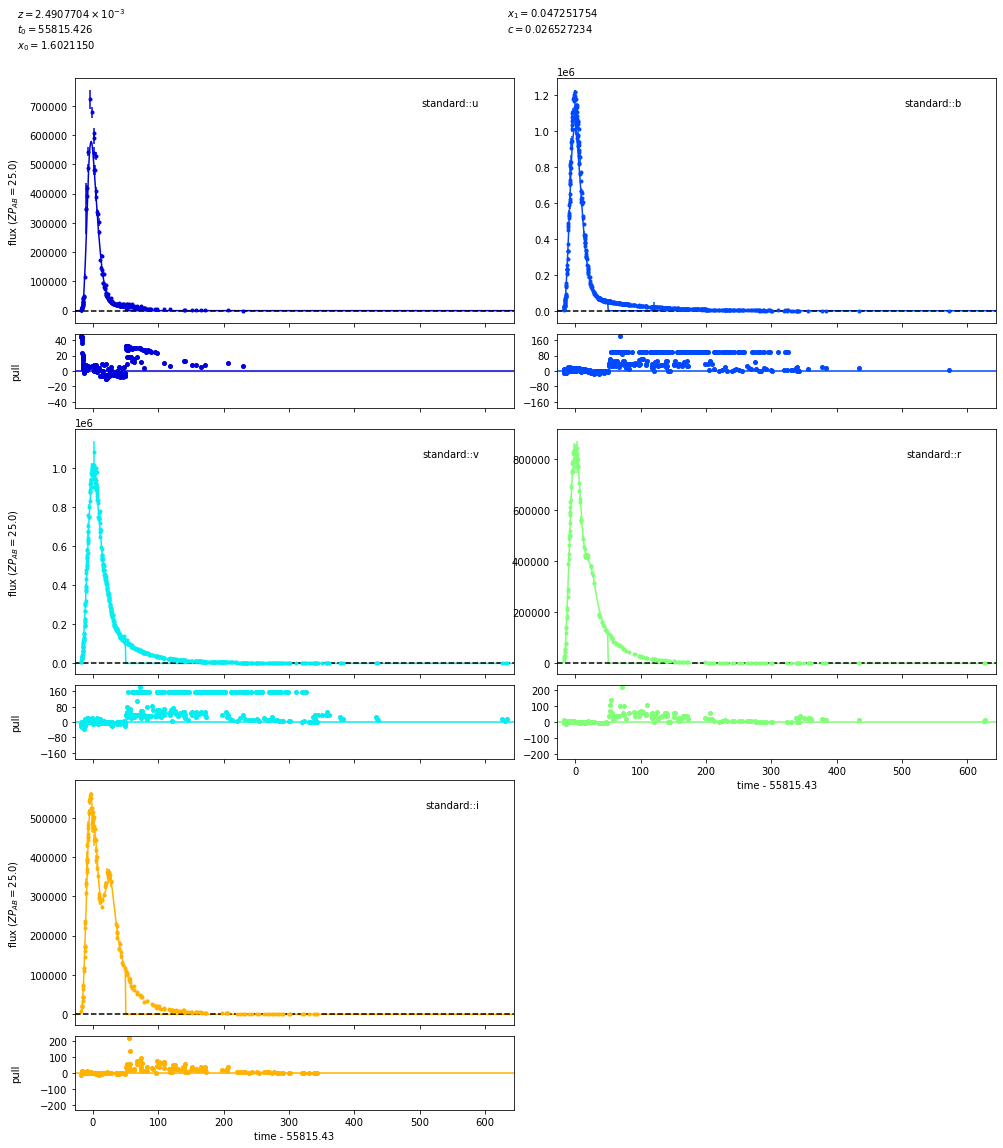

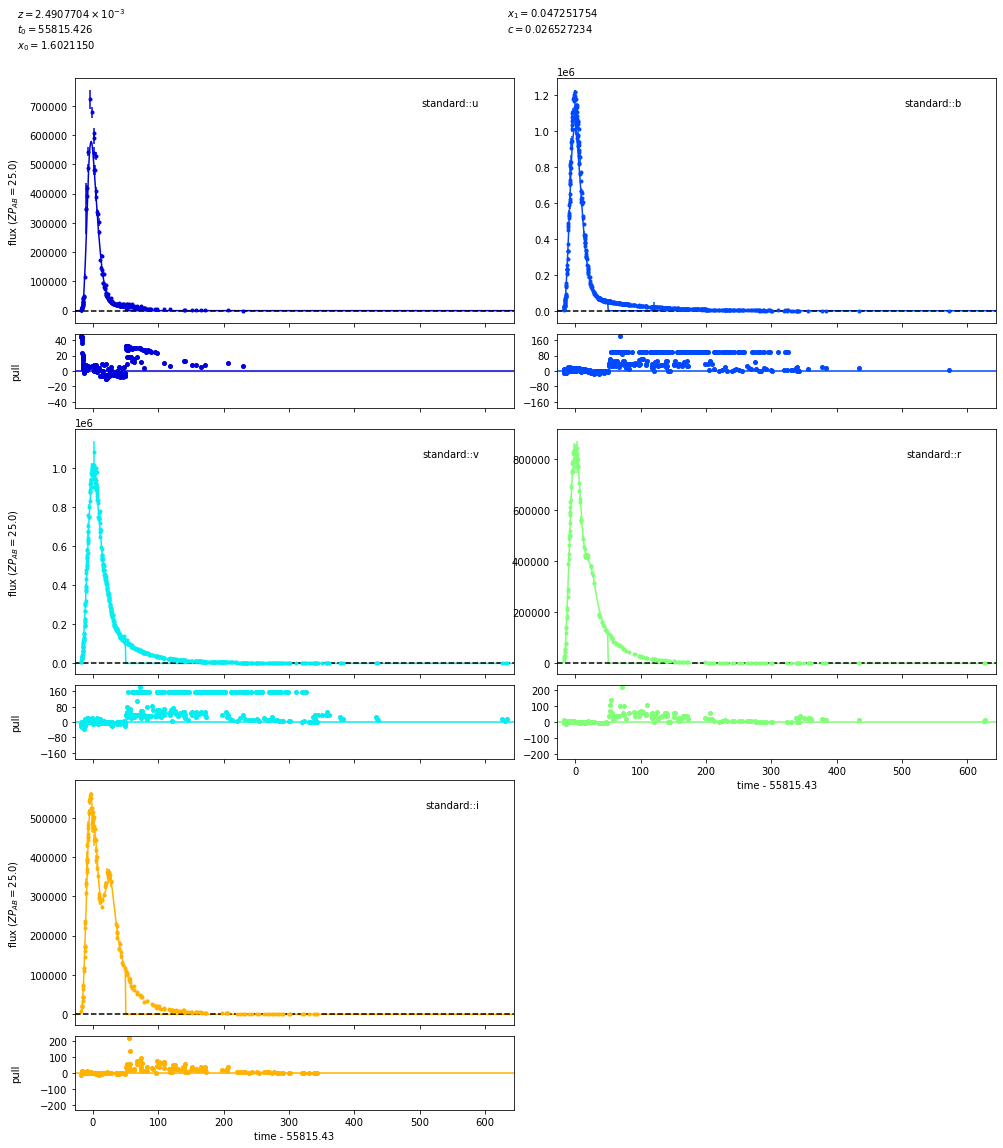

In [39]:
sncosmo.plot_lc(data_table, model=fitted_model, xfigsize=14)

In [29]:
#here is how I check to see if the band exists in sncosmo, there is more information here
# https://sncosmo.readthedocs.io/en/stable/bandpass-list.html

sncosmo.get_bandpass('fake')

Exception: 'fake' not in registry. Registered names: 'ps1::g', 'swope2::y', 'acswf::f606w', 'csphs', 'cspv3014', 'lsstg', 'bessellb', 'ps1::r', 'sdss::z', 'f225w', 'uvf775w', 'uvf625w', 'cspg', 'f110w', 'ztfr', 'uvot::uvm2', 'nicf160w', 'f150w', 'f435w', 'f625w', 'lsstr', 'f1140c', 'f335m', 'swope2::r', 'f184', 'f160w', 'cspv9844', 'f444w', 'f1280w', 'cspk', 'desy', 'f250m', 'uvot::b', 'f1500w', 'f2100w', 'standard::i', 'f350lp', 'f360m', 'bessellux', '2massks', 'keplercam::us', 'acswf::f775w', 'f336w', 'f218w', 'f438w', 'kepler', 'f555w', 'sdssr', 'f480m', 'desr', 'f770w', 'keplercam::b', 'uvf850lp', 'f1130w', 'cspjs', 'swope2::j', 'keplercam::r', 'f460m', 'desg', 'f689m', 'swope2::g', 'ps1::z', 'uvf475w', 'uvf555w', 'atlaso', 'lssty', 'desi', 'swope2::b', 'sdss::r', 'f158', 'keplercam::v', 'standard::b', 'f277w', 'swope2::i', 'f182m', 'f775w', 'cspr', 'f1000w', 'uvot::v', 'f850lp', 'desz', 'sdss::i', 'swope2::v2', 'cspjd', 'f560w', 'ztfi', 'sdssi', 'swope2::u', 'ztfg', '4shooter2::b', '4shooter2::us', 'f390w', 'uvf606w', 'f410m', 'nicf110w', 'f1065c', 'f763m', 'cspyd', 'f356w', 'sdss::u', 'nicmos2::f160w', 'f162m', 'atlasc', 'nicmos2::f110w', '2massh', 'uvot::uvw2', 'sdssg', 'lssti', '4shooter2::i', 'sdssu', 'f140w', 'ps1::y', 'f300x', 'f087', 'sdssz', 'f070w', 'f1800w', '4shooter2::r', 'f146', 'besselli', 'bessellr', 'f105w', 'uvot::white', 'uvot::uvw1', 'f2300c', 'cspi', 'f475w', 'keplercam::i', '4shooter2::v', 'f153m', 'cspys', 'bessellv', 'f606w', 'f098m', 'f115w', 'swope2::v', 'f140m', 'f210m', 'f129', 'f106', 'standard::r', 'cspb', 'f200w', 'f125w', 'ps1::i', 'f213', 'f1550c', 'ps1::w', 'sdss::g', 'f090w', 'ps1::open', 'cspu', 'uvf814w', 'f300m', 'lsstz', 'swope2::h', 'standard::v', 'f845m', 'f139m', 'standard::u', 'f430m', 'f275w', 'swope2::v1', 'lsstu', 'f127m', 'uvot::u', 'cspv3009', 'f2550w', 'csphd', '2massj', 'acswf::f850lp', 'f062'